### Load libraries

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn import linear_model
# plt.rcParams['figure.figsize'] = (25, 6)
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6) 

### Load dataset

In [99]:
play_cols = ['GameID','Drive','qtr','down','yrdline100','posteam','DefensiveTeam','TimeSecs','sp','ScoreDiff',
            'HomeTeam','AwayTeam']

In [100]:
spread_cols = ['eid','season','week','Home','Away','HomeScore','AwayScore','Day','Time','Favorite','Underdog','Spread','CoverOrNot']

In [101]:
data_files = glob.glob('data/new_data/pbp_20*.csv') # from 2009 to 2017

pbp_data = pd.DataFrame()
for f in data_files:
    d = pd.read_csv(f, usecols=play_cols)
    pbp_data = pd.concat([pbp_data, d])
pbp_data.shape

(388476, 12)

In [102]:
spread_data = pd.read_csv('data/point_spread.csv')

In [103]:
data = pd.merge(pbp_data, spread_data, on='GameID', how='left')

In [104]:
data = data.dropna(axis=0, how='any')

In [105]:
data = data[data['TimeSecs'] >= 0]

#### Columns to include in the formation of buckets [Down, TimeSecs, YdsToGo and Score Diff]

In [106]:
data['FavScoreDiff'] = data[['posteam','ScoreDiff','Favorite']].apply(
    lambda x: x['ScoreDiff'] if x['posteam']==x['Favorite'] else (-x['ScoreDiff']),axis=1)

In [107]:
data['favTeamOnBall'] = data[['Favorite','posteam']].apply(lambda x: 1 if x['Favorite']==x['posteam'] else -1, axis=1)

## Creating the buckets
For the first grid approach, we list two features
1. FavScoreDiff class: 9 (-35 ~, -25 ~ -34, -15 ~ -24, -5 ~ -14, 5 ~ -4, 6 ~ 15, 16 ~ 25, 26 ~ 35, 36+)
2. TimeLeftclass: 61, each minute belong to a single class (deal with time larger than 3600 -> OT)

In [137]:
bins = [-np.inf, -35, -25, -15, -5, 5, 15, 25, 35, np.inf]
data['FavScoreDiffClass'] = pd.cut(data['FavScoreDiff'], bins=bins, labels=range(9))

In [138]:
bins = range(0, 3601, 60)
bins.append(np.inf)
data['TimeSecsClass'] = pd.cut(data['TimeSecs'], bins=bins, labels=range(61), include_lowest=True)

In [140]:
bucket_cover = np.ones(shape=(9, 61))
bucket_notcover = np.ones(shape=(9, 61))

In [141]:
# TODO: Stupidly slow
bucket_cover_data = bucket_cover.copy()
bucket_notcover_data = bucket_notcover.copy()
for i, r in data.iterrows():
    score_idx = int(r['FavScoreDiffClass'])
    time_idx =  int(r['TimeSecsClass'])
    if r['CoverOrNot'] == 1:
        bucket_cover_data[score_idx][time_idx] += 1
    else:
        bucket_notcover_data[score_idx][time_idx] += 1

In [162]:
# Calculate initial probability based on bucket with data input
bucket_prob = bucket_cover_data.flatten() / (bucket_cover_data.flatten() + bucket_notcover_data.flatten())
bucket_prob = np.reshape(bucket_prob, (9, 61))

### Plot the score difference v.s. timeleft with the smoothing function (linear regression lines)

While fitting, filter out the buckets with 0.5 probabilities (which is considered as the one without probability)

#### Fixing score difference, graph of time left vs Prob

In [177]:
lin = linear_model.LinearRegression()
time = np.array(range(61))

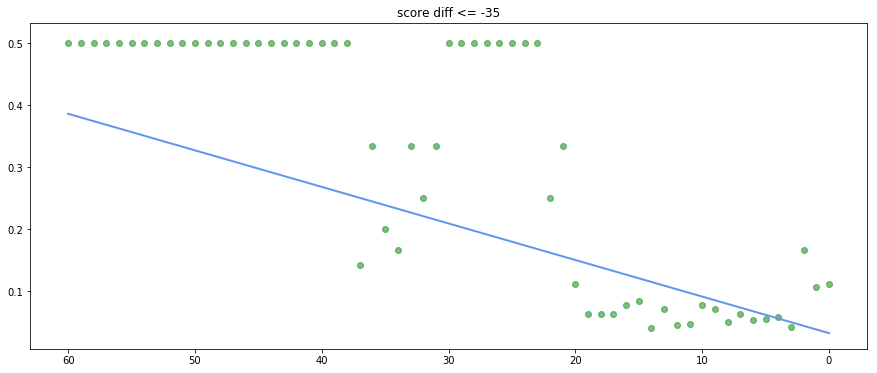

In [183]:
prob_idx = [True if p != 0.5 else False for p in bucket_prob[0]]
prob_fit = bucket_prob[0][prob_idx]
time_fit = time[prob_idx].reshape(-1, 1)

lin.fit(time_fit, prob_fit)
lin_y = lin.predict(time.reshape(-1, 1))

plt.figure()
plt.scatter(range(61), bucket_prob[0], c="g", alpha=0.5)
plt.plot(time.reshape(-1, 1), lin_y, color='cornflowerblue', linewidth=2,label='Linear regressor')

plt.title('score diff <= -35')
plt.gca().invert_xaxis()
plt.show()

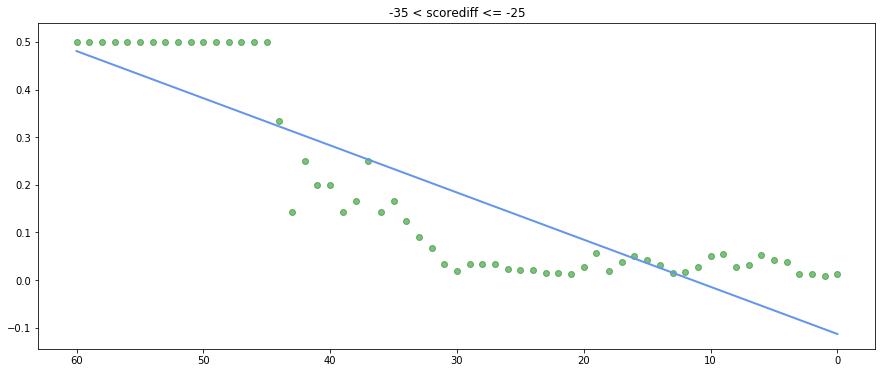

In [184]:
lin.fit(np.array(range(61)).reshape(-1, 1), bucket_prob[1])
line_y = lin.predict(np.array(range(61)).reshape(-1, 1))


plt.figure()
plt.scatter(range(61), bucket_prob[1], c="g", alpha=0.5)
plt.plot(range(61), line_y, color='cornflowerblue', linewidth=2,label='Linear regressor')

plt.title('-35 < scorediff <= -25')
plt.gca().invert_xaxis()
plt.show()

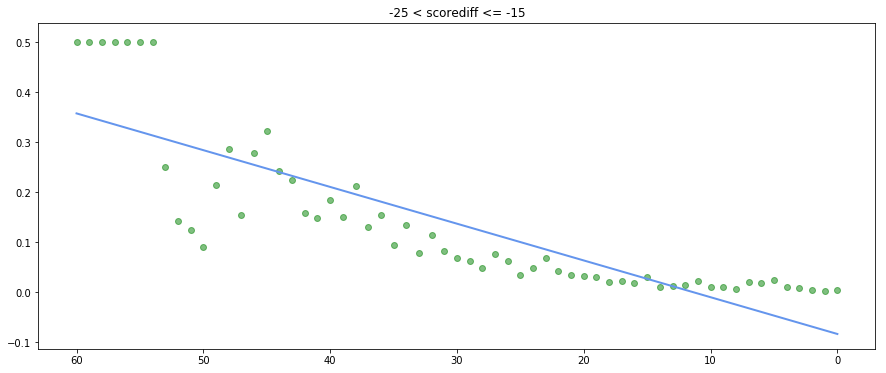

In [185]:
lin.fit(np.array(range(61)).reshape(-1, 1), bucket_prob[2])
line_y = lin.predict(np.array(range(61)).reshape(-1, 1))


plt.figure()
plt.scatter(range(61), bucket_prob[2], c="g", alpha=0.5)
plt.plot(range(61), line_y, color='cornflowerblue', linewidth=2,label='Linear regressor')

plt.title('-25 < scorediff <= -15')
plt.gca().invert_xaxis()
plt.show()

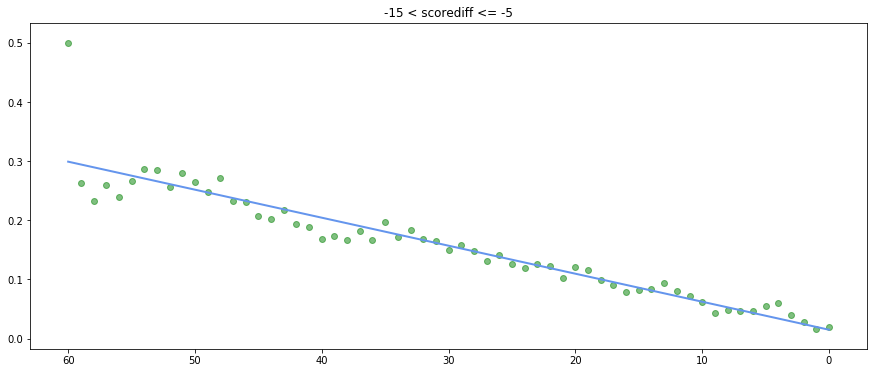

In [186]:
lin.fit(np.array(range(61)).reshape(-1, 1), bucket_prob[3])
line_y = lin.predict(np.array(range(61)).reshape(-1, 1))


plt.figure()
plt.scatter(range(61), bucket_prob[3], c="g", alpha=0.5)
plt.plot(range(61), line_y, color='cornflowerblue', linewidth=2,label='Linear regressor')

plt.title('-15 < scorediff <= -5')
plt.gca().invert_xaxis()
plt.show()

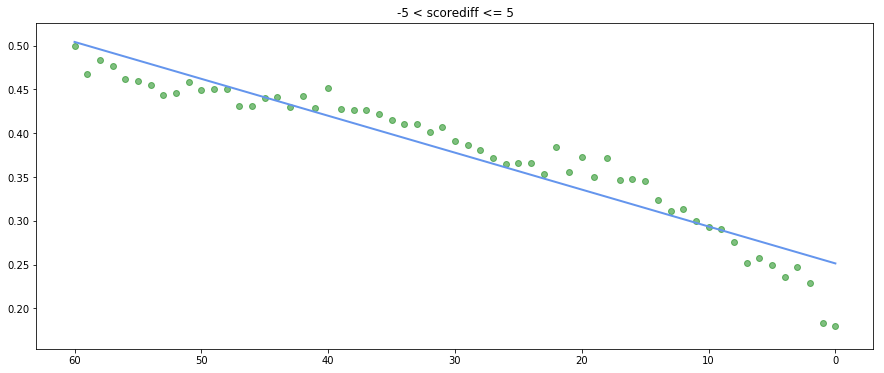

In [187]:
lin.fit(np.array(range(61)).reshape(-1, 1), bucket_prob[4])
line_y = lin.predict(np.array(range(61)).reshape(-1, 1))


plt.figure()
plt.scatter(range(61), bucket_prob[4], c="g", alpha=0.5)
plt.plot(range(61), line_y, color='cornflowerblue', linewidth=2,label='Linear regressor')

plt.title('-5 < scorediff <= 5')
plt.gca().invert_xaxis()
plt.show()

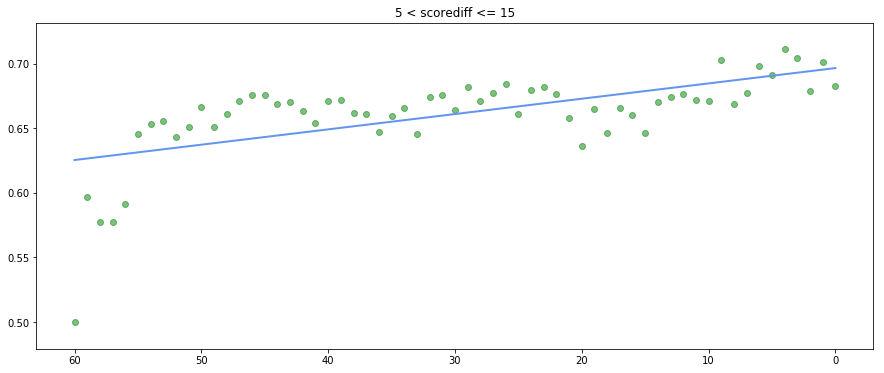

In [188]:
lin.fit(np.array(range(61)).reshape(-1, 1), bucket_prob[5])
line_y = lin.predict(np.array(range(61)).reshape(-1, 1))


plt.figure()
plt.scatter(range(61), bucket_prob[5], c="g", alpha=0.5)
plt.plot(range(61), line_y, color='cornflowerblue', linewidth=2,label='Linear regressor')

plt.title('5 < scorediff <= 15')
plt.gca().invert_xaxis()
plt.show()

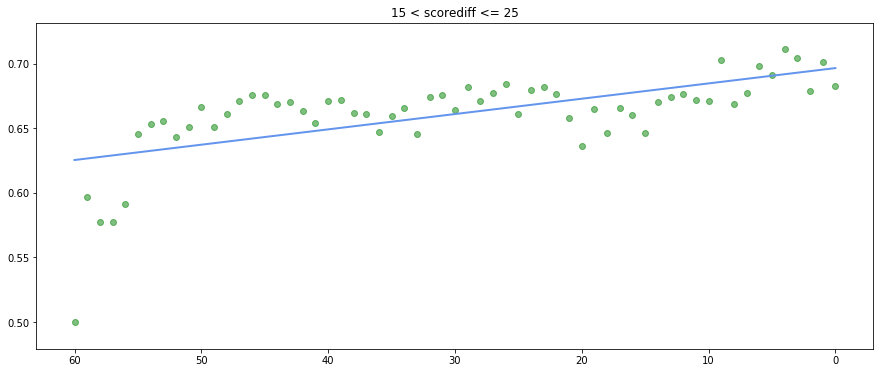

In [189]:
lin.fit(np.array(range(61)).reshape(-1, 1), bucket_prob[5])
line_y = lin.predict(np.array(range(61)).reshape(-1, 1))


plt.figure()
plt.scatter(range(61), bucket_prob[5], c="g", alpha=0.5)
plt.plot(range(61), line_y, color='cornflowerblue', linewidth=2,label='Linear regressor')

plt.title('15 < scorediff <= 25')
plt.gca().invert_xaxis()
plt.show()

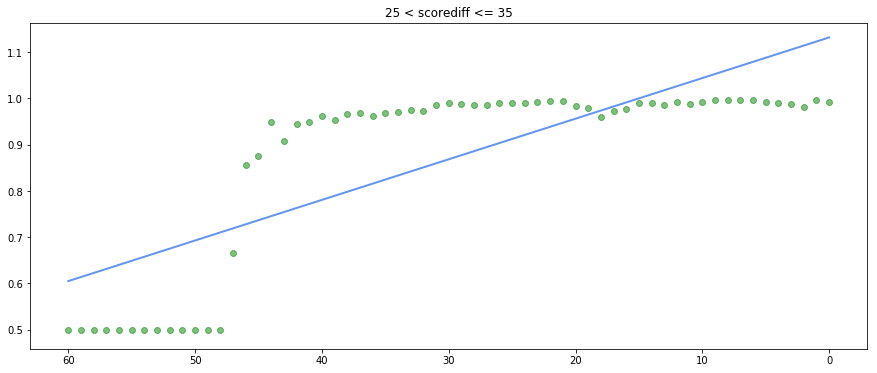

In [190]:
lin.fit(np.array(range(61)).reshape(-1, 1), bucket_prob[7])
line_y = lin.predict(np.array(range(61)).reshape(-1, 1))


plt.figure()
plt.scatter(range(61), bucket_prob[7], c="g", alpha=0.5)
plt.plot(range(61), line_y, color='cornflowerblue', linewidth=2,label='Linear regressor')

plt.title('25 < scorediff <= 35')
plt.gca().invert_xaxis()
plt.show()

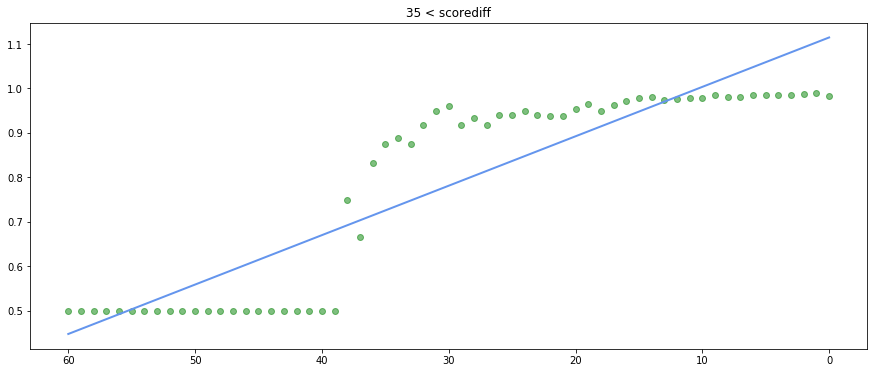

In [191]:
lin.fit(np.array(range(61)).reshape(-1, 1), bucket_prob[8])
line_y = lin.predict(np.array(range(61)).reshape(-1, 1))


plt.figure()
plt.scatter(range(61), bucket_prob[8], c="g", alpha=0.5)
plt.plot(range(61), line_y, color='cornflowerblue', linewidth=2,label='Linear regressor')

plt.title('35 < scorediff')
plt.gca().invert_xaxis()
plt.show()

### Update bucket probability based on the fitting lines
#### Notes
    1. for negative score difference
      * if the fitting lines give prob greater than 0.5, assign it to be 0.5
      * if the fitting lines give prob less than 0, assign it to be 0
    2. for positive score difference
      * if the fitting lines give prob greater than 1, assign it to be 1
      * if the fitting lines give prob less than 0.5, assign it to be 0.5
    3. for -5 < x < 5, leace it

In [195]:
for i in range(len(bucket_prob)):
    lin.fit(np.array(range(61)).reshape(-1, 1), bucket_prob[i])
    line_y = lin.predict(np.array(range(61)).reshape(-1, 1))
    for j in range(61):
        if i < 4:
            if line_y[j] < 0:
                bucket_prob[i][j] = 0
            elif line_y[j] > 0.5:
                bucket_prob[i][j] = 0.5
            else:
                bucket_prob[i][j] = line_y[j]
        elif i > 4:
            if line_y[j] > 1:
                bucket_prob[i][j] = 1
            elif line_y[j] < 0.5:
                bucket_prob[i][j] = 0.5
            else:
                bucket_prob[i][j] = line_y[j]

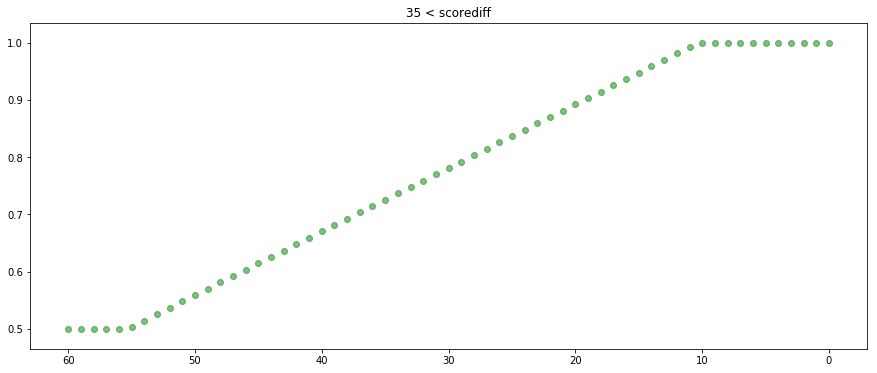

In [196]:
plt.figure()
plt.scatter(range(61), bucket_prob[8], c="g", alpha=0.5)
# plt.plot(range(61), line_y, color='cornflowerblue', linewidth=2,label='Linear regressor')

plt.title('35 < scorediff')
plt.gca().invert_xaxis()
plt.show()

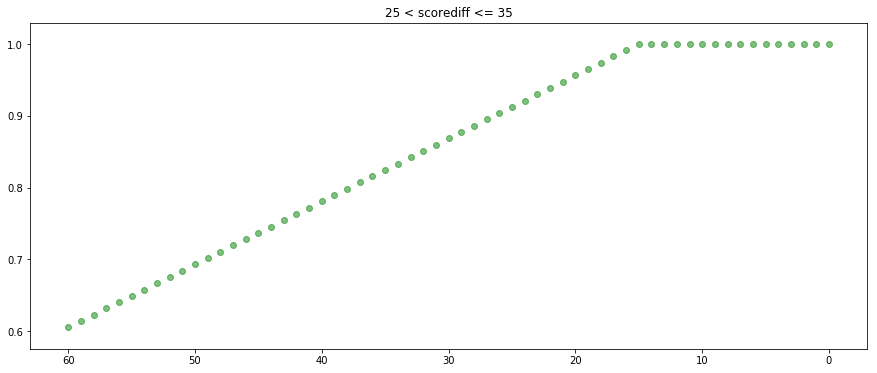

In [197]:
plt.figure()
plt.scatter(range(61), bucket_prob[7], c="g", alpha=0.5)

plt.title('25 < scorediff <= 35')
plt.gca().invert_xaxis()
plt.show()

## Plot an example

In [227]:
example = data[data['GameID'] == 2014090400]
example_score = []
example_score_dict = dict(zip(example.TimeSecs, example.ScoreDiff))
# TODO: this might be consider a programming problem
time_unique = example.TimeSecs.unique()
curr_score_diff = 0
for t in range(3600, -1, -1):
    if t in time_unique:
        curr_score_diff = example[example["TimeSecs"] == t].ScoreDiff.values[0]
    example_score.append(curr_score_diff)
example = pd.DataFrame(data=np.column_stack((range(3600, -1, -1), example_score)), columns=['timeleft', 'scorediff'])
bins = [-np.inf, -35, -25, -15, -5, 5, 15, 25, 35, np.inf]
example['scorediffClass'] = pd.cut(example['scorediff'], bins=bins, labels=range(9))
bins = range(0, 3601, 60)
bins.append(np.inf)
example['timeleftClass'] = pd.cut(example['timeleft'], bins=bins, labels=range(61), include_lowest=True)
for i, r in example.iterrows():
    score_idx = r['scorediffClass']
    time_idx  = r['timeleftClass']
    example.loc[i, 'prob'] = bucket_prob[score_idx][time_idx]
example

,timeleft,scorediff,scorediffClass,timeleftClass,prob
0,3600.0,0.0,4,59,0.46773
1,3599.0,0.0,4,59,0.46773
2,3598.0,0.0,4,59,0.46773
3,3597.0,0.0,4,59,0.46773
4,3596.0,0.0,4,59,0.46773
5,3595.0,0.0,4,59,0.46773
6,3594.0,0.0,4,59,0.46773
7,3593.0,0.0,4,59,0.46773
8,3592.0,0.0,4,59,0.46773
9,3591.0,0.0,4,59,0.46773


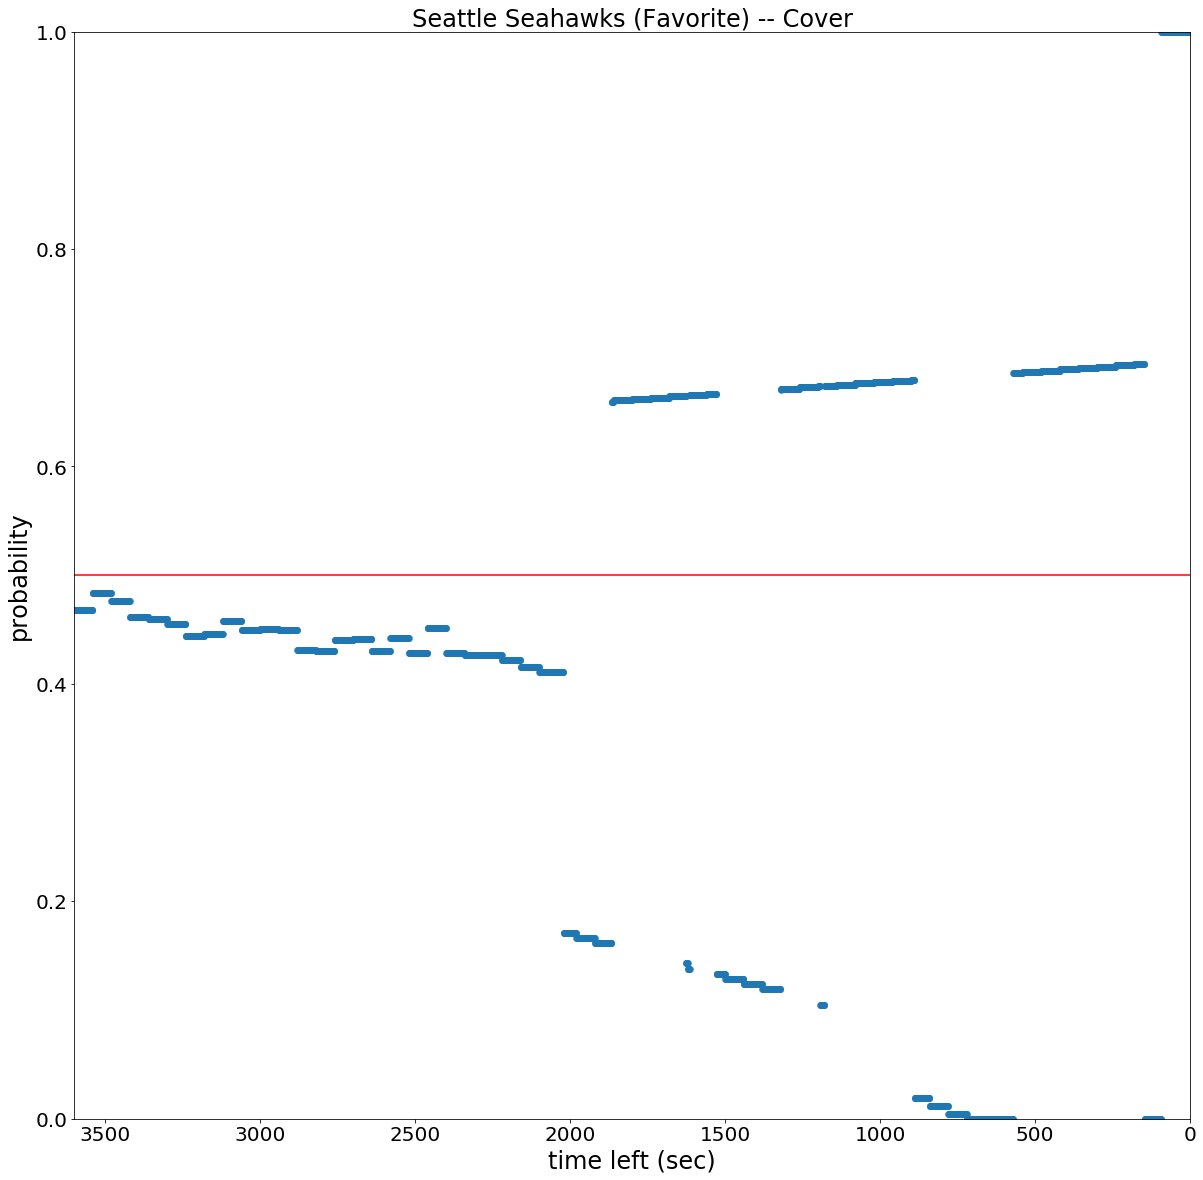

In [230]:
f, ax1 = plt.subplots(1, 1, figsize=(20, 20))


ax1.scatter(example.timeleft, example.prob, alpha=0.6)
# ax1.plot(d_f.lefttime, prob_f)
ax1.set_xlim(example.timeleft.max(), example.timeleft.min())
ax1.set_ylim(0, 1, 0.05)
ax1.axhline(y=0.5, color='r', linestyle='-')
ax1.set_title('Seattle Seahawks (Favorite) -- Cover', fontsize=24)
ax1.set_xlabel('time left (sec)', fontsize=24)
ax1.set_ylabel('probability', fontsize=24)
ax1.tick_params(labelsize=20)



plt.show()

## Plot the evaluation
look up the prob for all record in data

In [232]:
for i, r in data.iterrows():
    score_idx = r['FavScoreDiffClass']
    time_idx  = r['TimeSecsClass']
    data.loc[i, 'prob'] = bucket_prob[score_idx][time_idx]
data

,GameID,Drive,qtr,down,TimeSecs,yrdline100,posteam,DefensiveTeam,sp,ScoreDiff,...,Time,Favorite,Underdog,Spread,CoverOrNot,FavScoreDiff,favTeamOnBall,FavScoreDiffClass,TimeSecsClass,prob
1,2009091000,1,1,1.0,3593.0,58.0,PIT,TEN,0,0.0,...,8:30,PIT,TEN,-6.5,-1.0,0.0,1,4,59,0.467730
2,2009091000,1,1,2.0,3556.0,53.0,PIT,TEN,0,0.0,...,8:30,PIT,TEN,-6.5,-1.0,0.0,1,4,59,0.467730
3,2009091000,1,1,3.0,3515.0,56.0,PIT,TEN,0,0.0,...,8:30,PIT,TEN,-6.5,-1.0,0.0,1,4,58,0.483949
4,2009091000,1,1,4.0,3507.0,56.0,PIT,TEN,0,0.0,...,8:30,PIT,TEN,-6.5,-1.0,0.0,1,4,58,0.483949
5,2009091000,2,1,1.0,3496.0,98.0,TEN,PIT,0,0.0,...,8:30,PIT,TEN,-6.5,-1.0,-0.0,-1,4,58,0.483949
6,2009091000,2,1,2.0,3460.0,98.0,TEN,PIT,0,0.0,...,8:30,PIT,TEN,-6.5,-1.0,-0.0,-1,4,57,0.476080
7,2009091000,2,1,3.0,3431.0,94.0,TEN,PIT,0,0.0,...,8:30,PIT,TEN,-6.5,-1.0,-0.0,-1,4,57,0.476080
8,2009091000,2,1,4.0,3394.0,96.0,TEN,PIT,0,0.0,...,8:30,PIT,TEN,-6.5,-1.0,-0.0,-1,4,56,0.461262
9,2009091000,3,1,1.0,3384.0,43.0,PIT,TEN,0,0.0,...,8:30,PIT,TEN,-6.5,-1.0,0.0,1,4,56,0.461262
10,2009091000,3,1,2.0,3348.0,40.0,PIT,TEN,0,0.0,...,8:30,PIT,TEN,-6.5,-1.0,0.0,1,4,55,0.459459


In [233]:
nbins = 100

In [237]:
numr = data.groupby('prob').apply(lambda x: x[x['CoverOrNot']==1]['GameID'].unique().shape[0])
numr = numr.reset_index()
numr.columns=['prob','count']

denr = data.groupby('prob').apply(lambda x: x['GameID'].unique().shape[0])
denr = denr.reset_index()
denr.columns=['prob','count']
numr_bins, bins_n = np.histogram(numr['prob'],weights=numr['count'],bins = nbins)
denr_bins, bins_d = np.histogram(denr['prob'],weights=denr['count'], bins=nbins)
final_values = [float(numr_bins[i])/float(denr_bins[i]+1) for i in range(100)]

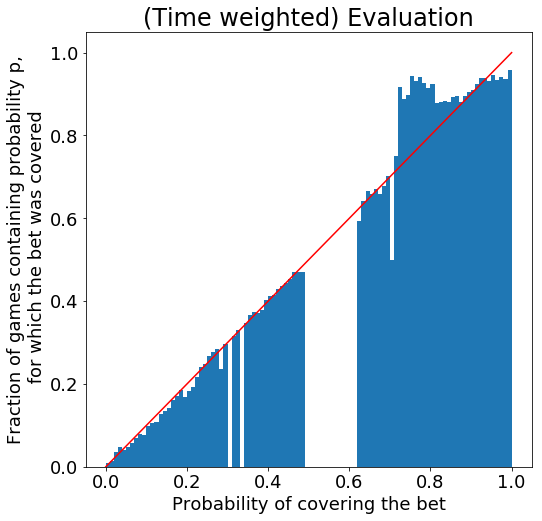

In [238]:
fig,ax = plt.subplots(figsize=(8,8))
ax.bar(bins_d[:-1],final_values, width=np.diff(bins_d),align='edge')
x = np.linspace(0,1)
ax.plot(x,x,color='red')

ax.set_title('(Time weighted) Evaluation', fontsize=24)
ax.set_xlabel('Probability of covering the bet', fontsize=18)
ax.set_ylabel("Fraction of games containing probability p,\n for which the bet was covered", fontsize=18)
ax.tick_params(labelsize=18)

plt.show()